# Classifier experimentation
Training data should be all set, let's take a quick look for sanity and then dig into building the text classifier. Plan here is to try a bunch of different things, follow any interesting ideas or insights and see what sticks. Some thoughts to get started:

1. ~~Should we use the DMLC XGBoost package or the gradient boosting classifier included in scikit-learn?~~ Use XGBoost via the scikit-learn API, classification performance is similar to scikit-learn's gradient boosting classifier, but it's much faster.

2. ~~Binary cross entropy seems like the obvious loss function to use, but what metrics should we track?~~

    - The default for XGBoost on this type of task is '**binary:logistic**' - but I haven't found exactly what that loss function is yet...
    - For scikit-learn gradient boosting classifier the default is '**log_loss**' which, according to the documentation 'refers to binomial and multinomial deviance, the same as used in logistic regression'.

    Ok, fine - only way I see to confirm that those are the same is dig into the source code. Definitely not worth the effort. At the end of the day, exactly what/how it is optimized and if it's the same between the two frameworks does not really matter - what we need is a way to evaluate both of them.

    I like false positive and false negative rates, we can get those from the confusion matrix (and also plot that at the same time). We should probably include accuracy as a percent for the less-statistically minded. We need a third to give a good look at the underlying probabilities rather than the 'calls'. Let's go with binary cross-entropy, in scikit-learn the **log_loss**.
    
3. ~~Do some hyperparameter tuning.~~ Done.
4. ~~Make sure we can do k-fold cross validation rather than looking at the test data all the time.~~ Done.
5. ~~Is there an easy way to do early stopping?~~ Yep - it's built into the sklearn API.
6. Is there an easy way to make training plots (i.e. training & validation loss over time)?
7. What about random forest?
8. Take a look at examples we have a hard time with.
9. Take a look at feature importance.
10. Maybe throw in some other methods (i.e. deep neural network/logistic regression), just for completeness.
11. ~~Build a results data structure so we can track the winners at each stage.~~ Done.

In [1]:
# Turn sampling on or off for rapid development
sample = False

# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from functools import partial
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, Trials

import configuration as config
import functions.notebook_helper as helper_funcs

/mnt/arkk/llm_detector/classifier


## 1. Training data
Let's take a look:

In [2]:
# Load the raw training data
training_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF)
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF)

# Take a sample if desired:
if sample is True:
    training_data_df = training_data_df.sample(1000)

percent_human_fragments = (len(training_data_df[training_data_df['Source'] == 'human']) / len(training_data_df)) * 100
print(f'Text fragments are {round(percent_human_fragments, 0)}% human\n')

training_data_df.info()
print()
training_data_df.head()

Text fragments are 50.0% human

<class 'pandas.core.frame.DataFrame'>
Index: 12716 entries, 0 to 12715
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  12716 non-null  int64  
 1   Fragment length (tokens)                 12716 non-null  int64  
 2   Dataset                                  12716 non-null  object 
 3   Source                                   12716 non-null  object 
 4   String                                   12716 non-null  object 
 5   Perplexity                               12716 non-null  float64
 6   Cross-perplexity                         12716 non-null  float64
 7   Perplexity ratio score                   12716 non-null  float64
 8   Perplexity ratio Kullback-Leibler score  12716 non-null  float64
 9   Human TF-IDF                             12716 non-null  float64
 10  Synthetic TF-IDF   

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,182,231,cc_news,human,a patrol shift due to the department being sho...,2.547,2.613281,0.974589,0.083768,-3.106254,-2.952138,0.933693,0.033565
1,32,43,cc_news,human,"athletes from Fairfield, Hillsboro and McClain...",3.443,3.337891,1.031597,0.203343,-3.068041,-2.733671,1.939918,0.025066
2,141,187,cnn,human,"could be habitable. If confirmed, it would sug...",2.664,2.703125,0.985549,0.084467,-2.825439,-2.858523,-0.188049,0.128369
3,185,267,cc_news,human,agreement to develop branded products and open...,2.506,2.587891,0.968302,0.094647,-3.384057,-3.228245,1.030274,0.028772
4,129,159,cc_news,synthetic,"in 1975.\nEven more to the point, Britain has ...",2.275,2.714844,0.838129,3.053975,-3.384582,-3.308561,0.508821,0.065821


OK, let's get the data into shape to train a classifier.

In [3]:
# Set length threshold
training_data_df = training_data_df[training_data_df['Fragment length (words)'] > 50]
testing_data_df = testing_data_df[testing_data_df['Fragment length (words)'] > 50]

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop unnecessary and highly correlated features
feature_drops = [
    # 'String', 
    'Dataset',
    # 'Fragment length (words)',
    # 'Cross-perplexity',
    # 'Human TF-IDF',
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# Keep a dataframe copy of the features for easy manipulation later and make 
# a numpy copy for training without the dataset or string columns
features_train = features_train_df.drop(['String'], axis=1).to_numpy()
features_test = features_test_df.drop(['String'], axis=1).to_numpy()

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')


Training data: 10525 examples
Test data: 2604 examples


Take a look at the features we are working with:

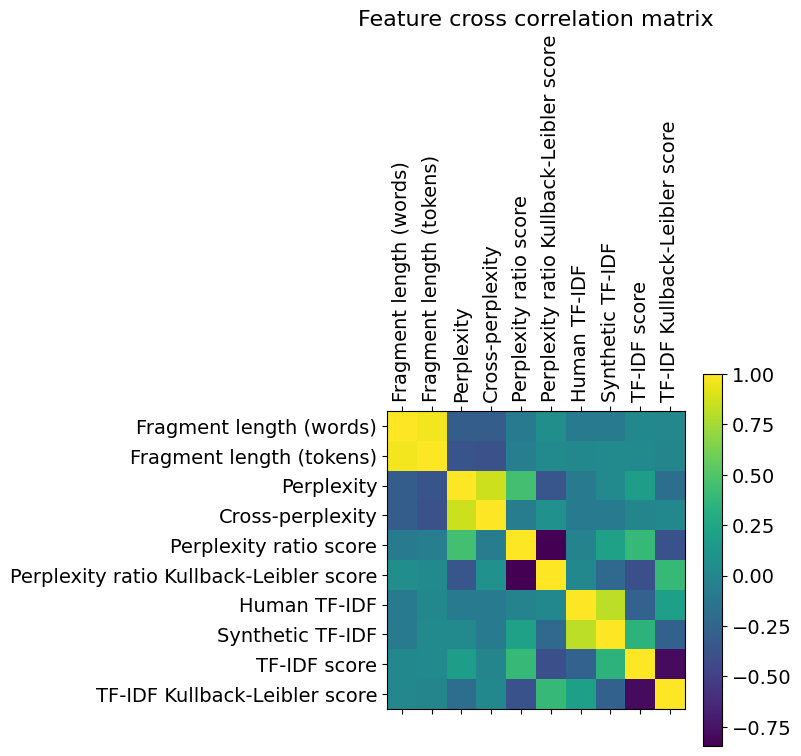

In [4]:
plt.matshow(features_train_df.drop('String', axis=1).corr())
plt.xticks(range(features_train_df.drop('String', axis=1).select_dtypes(['number']).shape[1]), features_train_df.drop('String', axis=1).select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(features_train_df.drop('String', axis=1).select_dtypes(['number']).shape[1]), features_train_df.drop('String', axis=1).select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)
plt.title('Feature cross correlation matrix', fontsize=16)
plt.show()

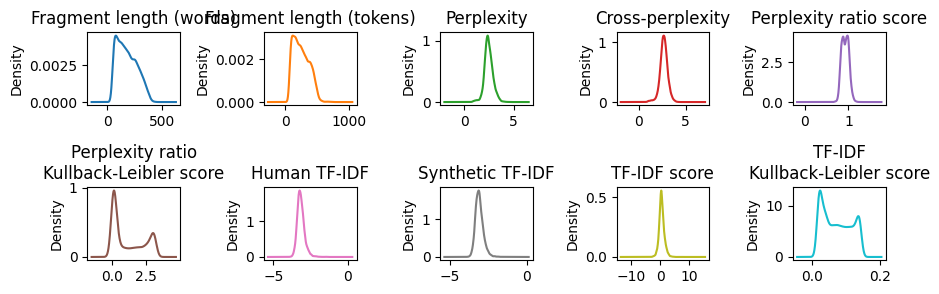

In [5]:
plot_titles = list(training_data_df.drop(['String', 'Source'], axis = 1).columns)
plot_titles = ['Perplexity ratio\nKullback-Leibler score' if x=='Perplexity ratio Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['TF-IDF\nKullback-Leibler score' if x=='TF-IDF Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Fragment length\n(words)' if x=='Fragment length (words)' else x for x in plot_titles]
plot_titles = ['Fragment length\n(tokens)' if x=='Fragment length (words)' else x for x in plot_titles]

n_cols = len(features_train_df.drop('String', axis=1).columns) // 2
n_rows = (len(features_train_df.drop('String', axis=1).columns) // 2) + (len(features_train_df.columns) % 2)

features_train_df.drop('String', axis=1).plot(title=plot_titles, kind='density', subplots=True, sharex=False, legend=False, layout=(n_rows,n_cols), figsize=(9,9))
plt.tight_layout()
plt.show()

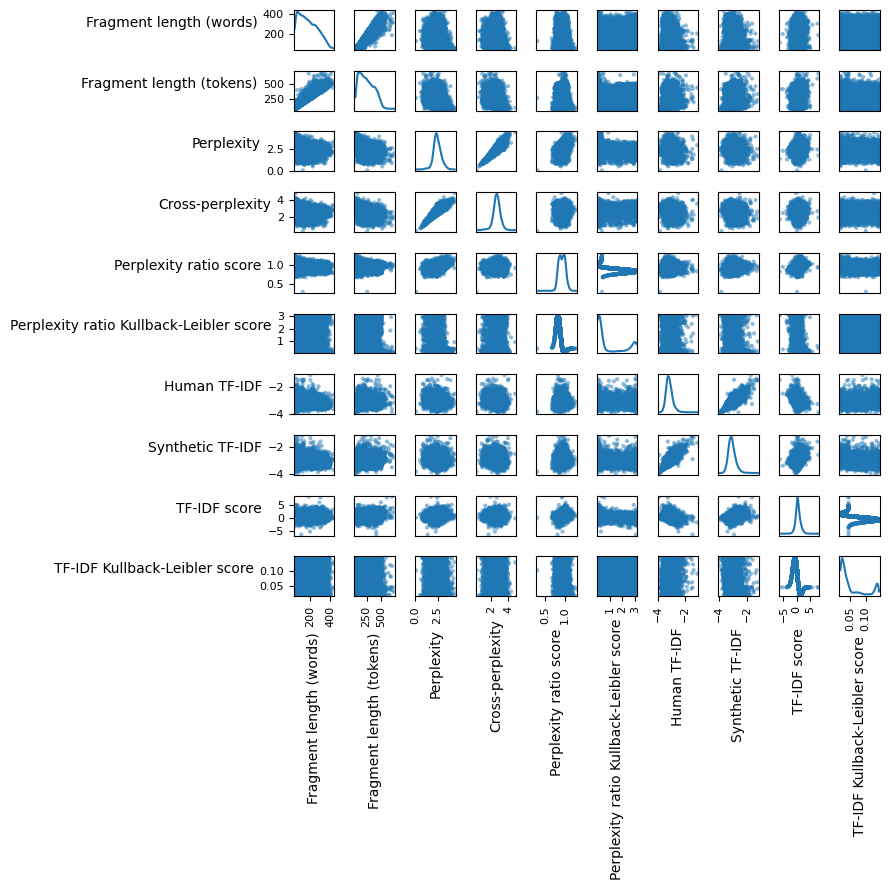

In [6]:
axes = scatter_matrix(features_train_df.drop('String', axis=1), figsize=(9,9), diagonal='kde')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
#plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

Let's also make a data structure to collect results for plotting as we go.

In [7]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

## 3. Off-the-shelf classifiers

In [8]:
# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

In [9]:
# Some parameters
kfolds = 3
random_state = 23
parallel_jobs = 16

### 2.1. XGBoost XGBClassifier

In [10]:
%%time 

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'XGBC')

Model is: <class 'xgboost.sklearn.XGBClassifier'>

CPU times: user 63.2 ms, sys: 199 ms, total: 262 ms
Wall time: 2.69 s


### 2.2. scikit-learn GradientBoostingClassifier

In [11]:
%%time

# Instantiate sklearn gradient boosting classifier
model = GradientBoostingClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'GBC')

Model is: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>

CPU times: user 32.2 ms, sys: 553 µs, total: 32.8 ms
Wall time: 4.57 s


### 2.3. scikit-learn HistGradientBoostingClassifier

In [12]:
%%time

from sklearn.ensemble import HistGradientBoostingClassifier

# Instantiate sklearn gradient boosting classifier
model = HistGradientBoostingClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'HGBC')

Model is: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>

CPU times: user 20.6 ms, sys: 3.14 ms, total: 23.8 ms
Wall time: 2.41 s


### 2.4. Results

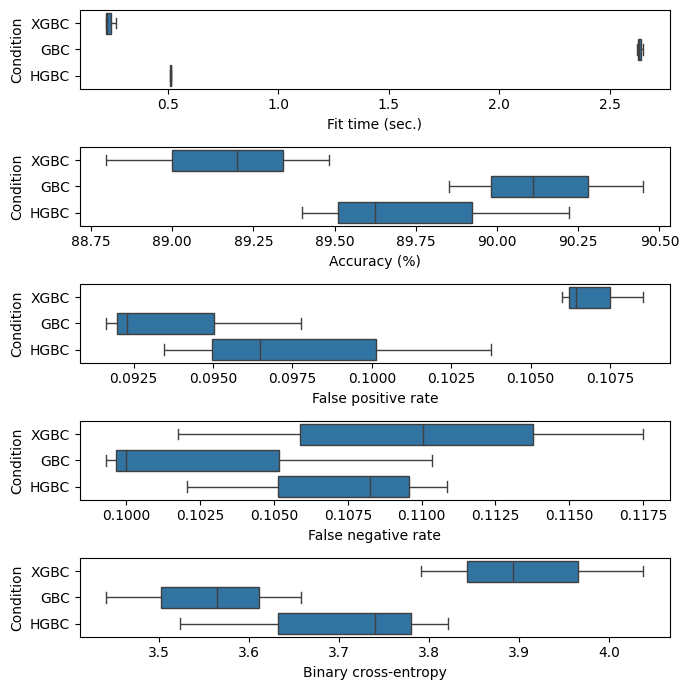

In [13]:
helper_funcs.plot_cross_validation(plots, results).show()

OK, pretty good - we are not over-fitting or just guessing the major class, we are in the mid-low 90% accuracy for all three implementation. This is actually a pretty good bump over the LLaMA2 based perplexity ratio score where we never got better than 88%. Problem now is as before, high false positive rate >= 15% for all three implementations. We may be able to mitigate that somewhat at the cost of false negatives with some threshold tuning later. First let's do some:

## 3. Hyperparameter optimization

In [14]:
# How many iterations to run
n_iter = 500

# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'max_iter': scope.int(hp.quniform('max_iter', 10, 1000, 1)),
       'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 15, 60, 1)),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 1000, 1)),
       'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 100, 1)),
       'l2_regularization': hp.uniform('l2_regularization', 0.001, 1.0)
}

### 3.1. HistGradientBoostingClassifier: single training-validation split

In [15]:
# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

100%|██████████| 500/500 [02:15<00:00,  3.68trial/s, best loss: 3.1957640750325536]


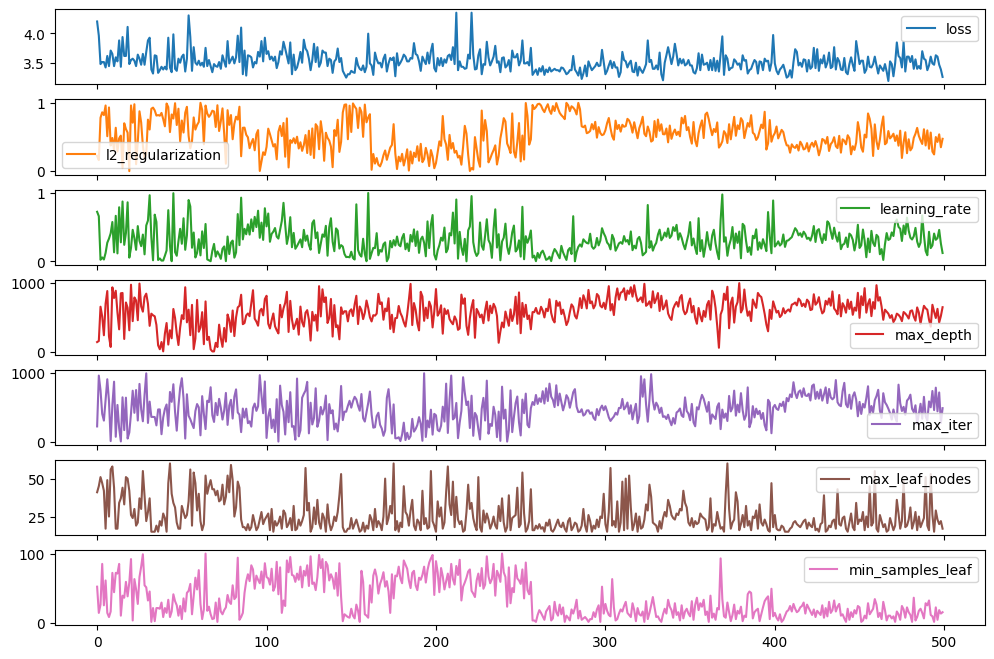

In [16]:
optimization_plot = helper_funcs.make_optimization_plot(trials.trials)

In [17]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best['learning_rate'],
    max_iter = int(best['max_iter']),
    max_leaf_nodes = int(best['max_leaf_nodes']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    l2_regularization = best['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized HGBC')


Optimized parameters:

 l2_regularization: 0.5874152880589818
 learning_rate: 0.3118091538821619
 max_depth: 555.0
 max_iter: 483.0
 max_leaf_nodes: 16.0
 min_samples_leaf: 10.0



### 3.2. HistGradientBoostingClassifier with k-fold cross validation

In [18]:
# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

# Set up trial logging
trials_cv = Trials()

best_cv = fmin(
       fn = partial(
              helper_funcs.hyperopt_cv,
              model = model,
              features = features_train, 
              labels = labels_train
       ),
       space = space,           # Parameter: value dictionary
       algo = tpe.suggest,      # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,      # Maximum number of iterations
       trials = trials_cv       # Logging
)

100%|██████████| 500/500 [22:51<00:00,  2.74s/trial, best loss: 3.4680542970182464]  


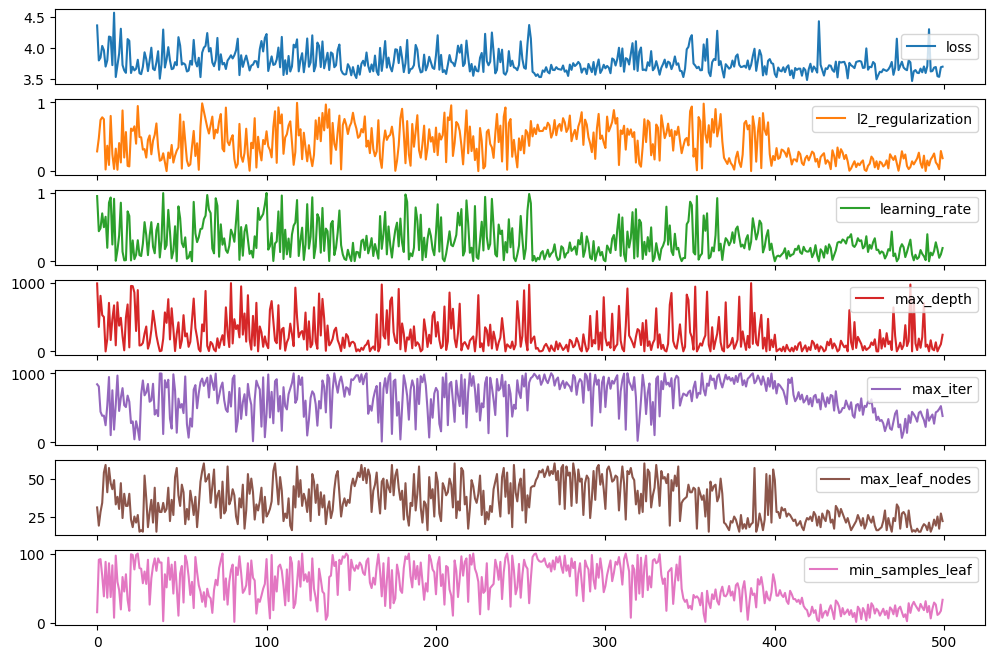

In [19]:
optimization_plot = helper_funcs.make_optimization_plot(trials_cv.trials)

In [20]:
print('Optimized parameters:\n')

for key, value in best_cv.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best_cv['learning_rate'],
    max_iter = int(best_cv['max_iter']),
    max_leaf_nodes = int(best_cv['max_leaf_nodes']),
    max_depth = int(best_cv['max_depth']),
    min_samples_leaf = int(best_cv['min_samples_leaf']),
    l2_regularization = best_cv['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'CV Optimized HGBC')

Optimized parameters:

 l2_regularization: 0.14360542887054983
 learning_rate: 0.09931598211858406
 max_depth: 2.0
 max_iter: 442.0
 max_leaf_nodes: 15.0
 min_samples_leaf: 25.0



### 3.3. XGBClassifier: single training-validation split

In [21]:
# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'gamma': hp.uniform('gamma', 0.0, 10.0),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 100, 1)),
       'min_child_weight': hp.uniform('min_child_weight', 0.0, 10.0),
       'subsample': hp.uniform('subsample', 0.5, 1.0),
       'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
       'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
       'n_estimators': scope.int(hp.quniform('n_estimators', 1, 100, 1)),
       'num_parallel_tree': scope.int(hp.quniform('num_parallel_tree', 1, 10, 1))
}

# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = XGBClassifier()

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

100%|██████████| 500/500 [01:59<00:00,  4.18trial/s, best loss: 3.0588027575311583]


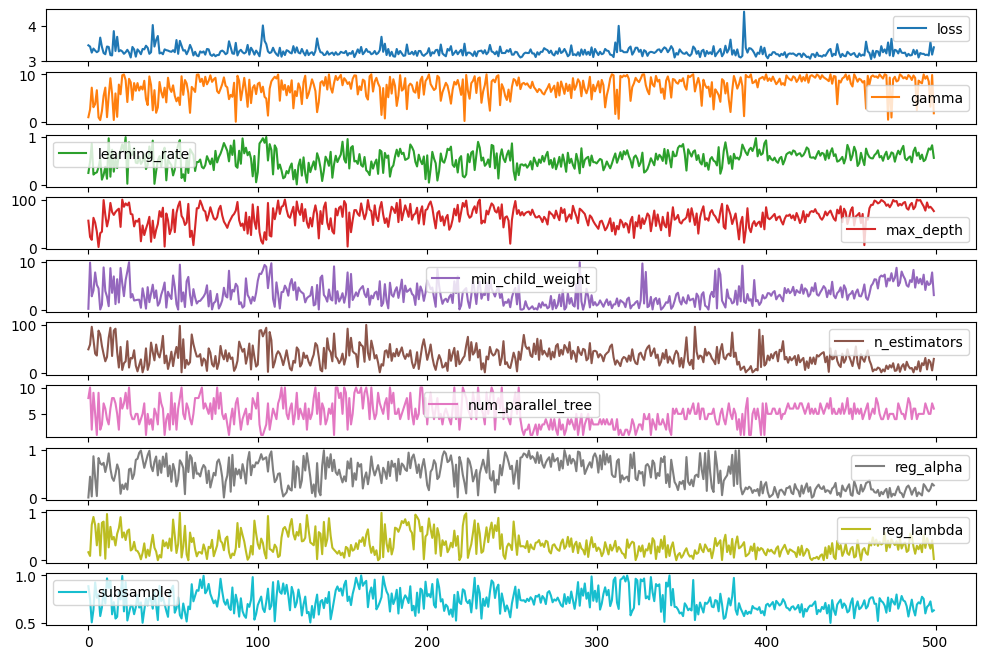

In [22]:
optimization_plot = helper_funcs.make_optimization_plot(trials.trials)

In [23]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = XGBClassifier(
    learning_rate = best['learning_rate'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    reg_alpha = best['reg_alpha'],
    reg_lambda = int(best['reg_lambda']),
    n_estimators = int(best['num_parallel_tree'])
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized XGBC')


Optimized parameters:

 gamma: 9.49690409538339
 learning_rate: 0.5532371799318495
 max_depth: 89.0
 min_child_weight: 4.984677251833581
 n_estimators: 17.0
 num_parallel_tree: 5.0
 reg_alpha: 0.17142222022087544
 reg_lambda: 0.3087036074490695
 subsample: 0.7676960679043192



### 3.4. Results

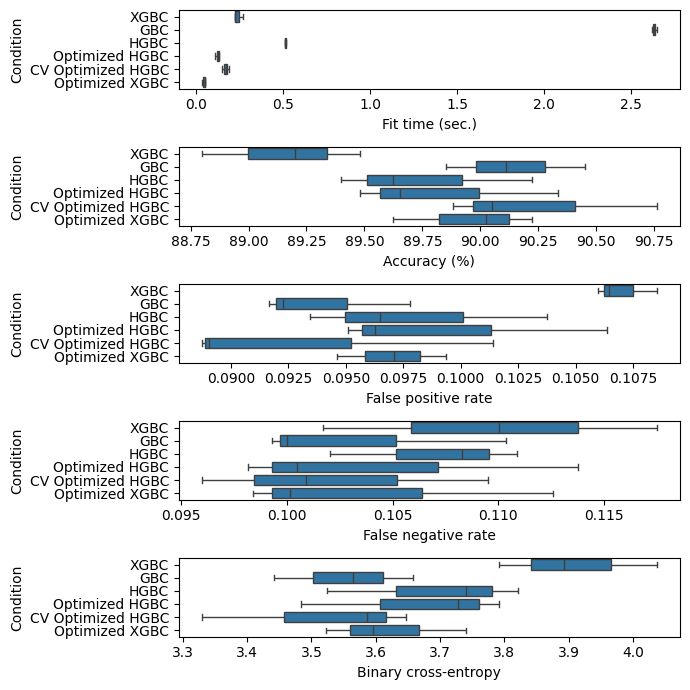

In [24]:
helper_funcs.plot_cross_validation(plots, results).show()

## 4. Mis-classified examples

At this point, it feels like we have hit the limit of what the classifier is capable of. Doesn't seem like we will be able to get past 95% accuracy or below ~15% false positive rate without changing/improving features and/or data. Let's take a look at the text fragments which are bing miss-classified and see if anything jumps out.

The current winner (based on binary cross-entropy) is the optimized scikit-learn **HistGradientBoostingClassifier** - so let's train one up to play with.

In [25]:
# Optimized parameters:

optimized_params = {
    'l2_regularization': 0.25139838576373374,
    'learning_rate': 0.03827830315392269,
    'max_depth': 795,
    'max_iter': 792,
    'max_leaf_nodes': 16,
    'min_samples_leaf': 48
}

# Instantiate and train model
model = HistGradientBoostingClassifier(random_state = random_state, **optimized_params)
model.fit(features_train, labels_train)

# Make predictions for text examples
predictions = model.predict(features_test)

In [26]:
# Find the indices of mis-classified examples
test_error_indices = []
i = 0
n = 1

for features, label, prediction in zip(features_test, labels_test, predictions):
    if label != prediction:
        test_error_indices.append(i)

    n += 1
    i += 1

print(f'\nHave {len(test_error_indices)} ({round((len(test_error_indices) / len(predictions)) * 100, 1)}%) miss-classed text fragments from the test set')


Have 318 (12.2%) miss-classed text fragments from the test set


In [27]:
# Recover the miss-classed fragments
errors = []
test_strings = list(features_test_df['String'])

for i in test_error_indices:
    errors.append(test_strings[i])

for error in errors[:10]:
    print(f'{error}\n\n')

Florida International University bridge collapsed Saturday while vehicles were crossing, police say. At least three people were killed. (Michael Laughlin/South Florida Sun-Sentinel via AP) The Latest: 1st lawsuit filed after Florida bridge collapse 1 / 1 Back to Gallery 9 a.m. Florida officials have identified three people killed when a pedestrian bridge collapsed onto a major road and parked cars underneath. The Florida Highway Patrol identifies the dead as Brandon Brownfield, an FIU student; and Alexander Dosil Almiro Soto. An 18-year-old woman also died in the accident. The bridge collapsed while construction was underway Thursday afternoon. The Miami-Dade police and fire departments, the Florida Highway Patrol and other agencies responded. The National Transportation Safety Board is investigating.


coverage and for their prescription drugs. Many Americans have received free contraceptives, mammograms, colonoscopies and cholesterol tests. And small business employees with older and

Hmm, hard to draw any easy conclusions why these are being miss-classified. Some are short or very low entropy, but many are not. Maybe let's look at our features' distributions in the correctly and incorrectly classed fragments.

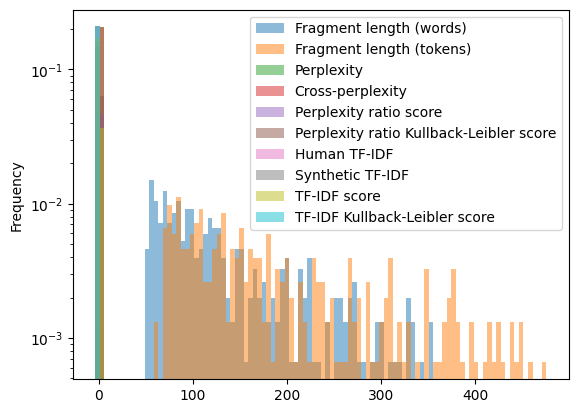

In [28]:
errors = features_test_df.iloc[test_error_indices]
ax = errors.plot.hist(bins=100, alpha=0.5, density=True, log=True)

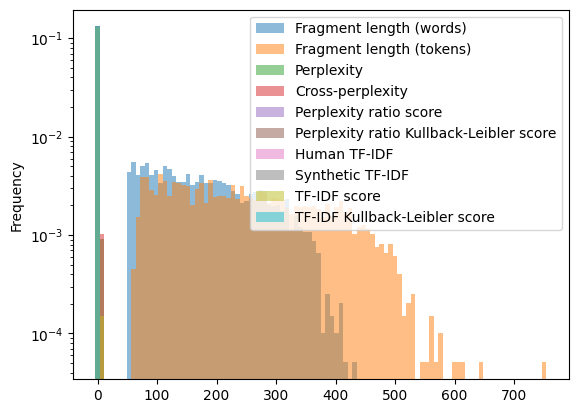

In [29]:
ax = features_test_df.plot.hist(bins=100, alpha=0.5, density=True, log=True)

Yeah, nothing jumps right out at me... Maybe let's just do some general feature checking.

## 6. Synthetic features

In [30]:
# Perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree = 3)
poly_features = trans.fit_transform(features_train)

# Split into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(poly_features, labels_train, test_size = 0.3, random_state = 0)

In [31]:
# Fit model on training data
model = GradientBoostingClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 90.6%


Nope, OK, need to move on here. Looks like there is no easy way to improve without changes to the data pipeline... We can revisit this later.